In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange

from segm.data.ade20k import ADE20K_CATS_PATH
from segm.data.factory import create_dataset
from segm.data.utils import dataset_cat_description, seg_to_rgb
from segm.model import utils
from segm.model.factory import load_model


In [2]:
device = "cuda"
model_dir = Path("small_32_vanilla")


In [3]:
model, variant = load_model(model_dir / "checkpoint.pth")
model.to(device)


Segmenter(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 384, kernel_size=(32, 32), stride=(32, 32))
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (mlp): FeedForward(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate=none)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
      )
      (1): Block(
      

In [4]:
window_size = variant["inference_kwargs"]["window_size"]
window_stride = variant["inference_kwargs"]["window_stride"]


In [5]:
dataset_kwargs = variant["dataset_kwargs"]
val_kwargs = dataset_kwargs.copy()
val_kwargs["split"] = "val"
val_kwargs["batch_size"] = 1
val_kwargs["crop"] = False
val_loader = create_dataset(val_kwargs)


2022-09-30 15:48:25,700 - mmseg - INFO - Loaded 2000 images


Use normalization: {'mean': (127.5, 127.5, 127.5), 'std': (127.5, 127.5, 127.5)}


In [6]:
cat_names, cat_colors = dataset_cat_description(ADE20K_CATS_PATH)


In [7]:
pass


In [8]:
val_seg_gt = val_loader.dataset.get_gt_seg_maps()
val_iter = iter(val_loader)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)


In [14]:
batch = next(val_iter)


In [15]:
ims = [im.to(device) for im in batch["im"]]
ims_metas = batch["im_metas"]
ori_shape = ims_metas[0]["ori_shape"]
ori_shape = (ori_shape[0].item(), ori_shape[1].item())
filename = batch["im_metas"][0]["ori_filename"][0]
# seg_pred = utils.inference(
#                 model,
#                 ims,
#                 ims_metas,
#                 ori_shape,
#                 512,
#                 512,
#                 batch_size=1,
#             )  # 150x512x683
C = model.n_cls
seg_map = torch.zeros((C, ori_shape[0], ori_shape[1]), device=device)
for im, im_metas in zip(ims, ims_metas):
    im = im.to(device)
    im = utils.resize(im, window_size)
    # seg_gt = torch.Tensor(val_seg_gt[filename]).long().unsqueeze(0).unsqueeze(0).to(device)
    # seg_gt = utils.resize(seg_gt, window_size, "nearest")
    flip = im_metas["flip"]
    windows = utils.sliding_window(im, flip, window_size, window_stride)
    # windows_seg_gt = utils.sliding_window(seg_gt, flip, window_size, window_stride)
    crops = torch.stack(windows.pop("crop"))[:, 0]
    # crops_seg_gt = torch.stack(windows_seg_gt.pop("crop"))[:, 0]
    B = len(crops)
    WB = val_loader.batch_size
    seg_maps = torch.zeros((B, C, window_size, window_size), device=im.device)
    with torch.no_grad():
        for i in range(0, B, WB):
            seg_maps[i : i + WB] = model.forward(crops[i : i + WB])
    windows["seg_maps"] = seg_maps
    # loss = criterion(seg_maps, crops_seg_gt.squeeze())
    windows_gt = utils.sliding_window(im, flip, window_size, window_stride)
    im_seg_map = utils.merge_windows(windows, window_size, ori_shape)
    seg_map += im_seg_map
seg_map /= len(ims)


In [16]:
seg_map_gt = torch.Tensor(val_seg_gt[filename]).long().unsqueeze(0)

loss = criterion(
    seg_map.unsqueeze(0),
    seg_map_gt.to(device),
)

seg_map = seg_map.argmax(0, keepdim=True)
seg_rgb = seg_to_rgb(seg_map, cat_colors)
seg_gt_rgb = seg_to_rgb(seg_map_gt, cat_colors)


In [17]:
loss


tensor(0.3577, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'prediction')

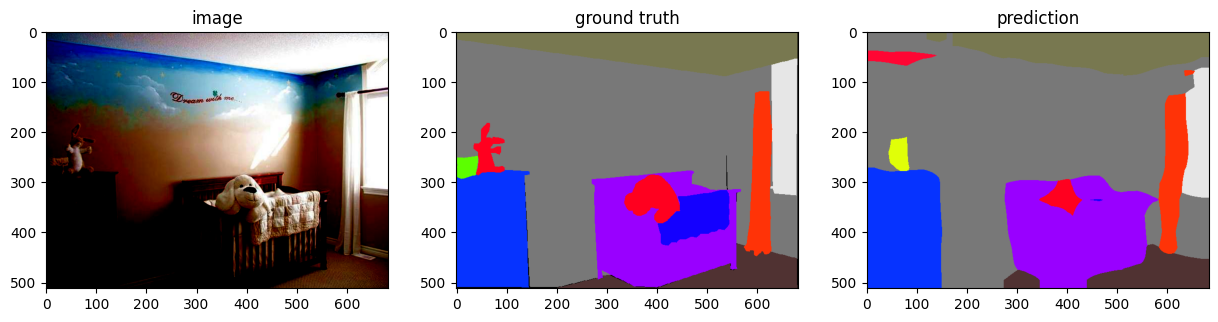

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
axes[0].imshow(rearrange(ims[0], "b c h w -> (b h) w c").cpu())
axes[0].set_title("image")
axes[1].imshow(seg_gt_rgb[0])
axes[1].set_title("ground truth")
axes[2].imshow(seg_rgb[0])
axes[2].set_title("prediction")
